<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/GP15_Defining_Watermass_Subtypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install py_pcha
!pip install gsw

     |████████████████████████████████| 2.4 MB 8.2 MB/s 


Grab the data

In [3]:
!wget https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0237935/GLODAPv2.2021_Pacific_Ocean.csv -O GLODAPv2.2021_Pacific_Ocean.csv
!wget https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0237935/GLODAPv2.2021_Arctic_Ocean.csv -O GLODAPv2.2021_Arctic_Ocean.csv
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr" -O GLODAPv2.2019_Pacific_Ocean.csv && rm -rf /tmp/cookies.txt

--2021-11-04 09:23:55--  https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0237935/GLODAPv2.2021_Pacific_Ocean.csv
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.167, 205.167.25.168, 205.167.25.171, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247559175 (236M) [text/csv]
Saving to: ‘GLODAPv2.2021_Pacific_Ocean.csv’

GLODAPv2.2021_Pacif 100%[===================>] 236.09M  34.7MB/s    in 7.7s    

2021-11-04 09:24:04 (30.8 MB/s) - ‘GLODAPv2.2021_Pacific_Ocean.csv’ saved [247559175/247559175]

--2021-11-04 09:24:04--  https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0237935/GLODAPv2.2021_Arctic_Ocean.csv
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.178, 205.167.25.167, 205.167.25.168, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65348597 (62M) [text/cs

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas
import gsw

Read in the data frame and pick a subset of columns

In [5]:
colnames_subset = ["G2latitude", 'G2longitude', 'G2year', 'G2depth',
                   'G2pressure', 'G2temperature','G2salinity','G2oxygen',
                   'G2silicate', 'G2nitrate', 'G2phosphate', 'G2sigma0']


pacific_df = pandas.read_csv("GLODAPv2.2021_Pacific_Ocean.csv",
                     na_values = -9999)[colnames_subset]

arctic_df = pandas.read_csv("GLODAPv2.2021_Arctic_Ocean.csv",
                     na_values = -9999)[colnames_subset]

df = pandas.concat([pacific_df, arctic_df], axis=0)

df.columns =["latitude", 'longitude', 'year', 'depth',
             'pressure', 'temperature','salinity','oxygen',
             'silicate', 'nitrate', 'phosphate', 'sigma0']                                     

df['NO'] = df['oxygen'] + (df['nitrate']*9.68)
df['PO'] = df['oxygen'] + (df['phosphate']*155)
df['potential_temp'] = gsw.pt_from_t(df['salinity'],
                                df['temperature'],
                                df['pressure'],
                                df['sigma0'])
df["absolute_salinity"] = gsw.SA_from_SP(
    SP=df["salinity"], p=df["pressure"],
    lon=df["longitude"], lat=df["latitude"])
df["conservative_temp"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                  t=df["temperature"],
                                  p=df["pressure"])
df["sigma2"] = gsw.sigma2(SA=df["absolute_salinity"],CT=df["conservative_temp"])
df["sigma4"] = gsw.sigma4(SA=df["absolute_salinity"],CT=df["conservative_temp"])

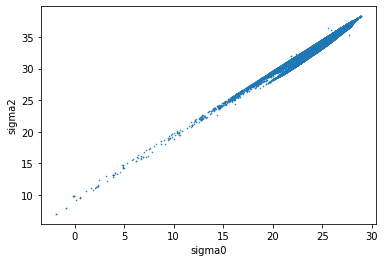

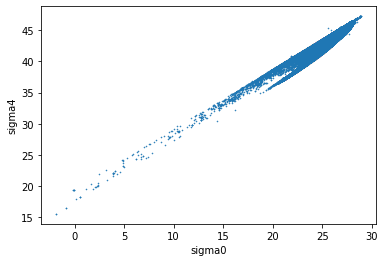

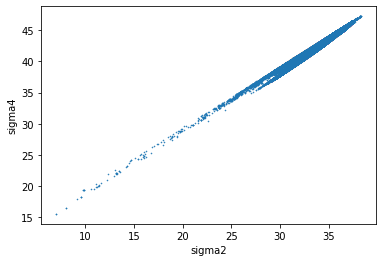

In [6]:
from matplotlib import pyplot as plt

plt.scatter(df["sigma0"], df["sigma2"], s=0.3)
plt.xlabel("sigma0")
plt.ylabel("sigma2")
plt.show()

plt.scatter(df["sigma0"], df["sigma4"], s=0.3)
plt.xlabel("sigma0")
plt.ylabel("sigma4")
plt.show()

plt.scatter(df["sigma2"], df["sigma4"], s=0.3)
plt.xlabel("sigma2")
plt.ylabel("sigma4")
plt.show()

In [7]:
#ARCH_ANALYSIS_FEATURES = ["conservative_temp", "absolute_salinity",
#                          "silicate", "NO", "PO"]
ARCH_ANALYSIS_FEATURES = ["conservative_temp", "absolute_salinity",
                          "silicate", "nitrate", "phosphate", "oxygen"]
ALL_FEATURES_TO_AVERAGE = ARCH_ANALYSIS_FEATURES+["latitude", "longitude"]

#feature_weights = {"conservative_temp": 56.0,
#                   "absolute_salinity": 80.0,
#                   "silicate": 3.0,
#                   "NO": 5.0,
#                   "PO": 5.0}

#Weight all features equally for now...
feature_weights = {"conservative_temp": 1.0,
                   "absolute_salinity": 1.0,
                   "silicate": 1.0,
                   "NO": 1.0,
                   "PO": 1.0,
                   "nitrate": 1.0,
                   "phosphate": 1.0,
                   "oxygen": 1.0}

print("Standardizing feature values")
#Let's standardize each column by subtracting mean,
# dividing by standard deviation and multiplying by the feature weights.
# Call it a 'features' dataframe
#keep track of mean and std in order to do inverse transform
colname_to_mean = {}
colname_to_std = {} 
for colname in ARCH_ANALYSIS_FEATURES:
  vals = np.array(df[colname])
  #use nanmean and nanstd to ignore nan values for now
  mean = np.nanmean(vals)
  std = np.nanstd(vals)
  colname_to_mean[colname] = mean
  colname_to_std[colname] = std
  df['standardized_'+colname] = feature_weights[colname]*(vals-mean)/std

#Since imputation takes a while on such a large dataset, we
# will just drop rows that have missing values
print("Proportions of missing values:")
print(np.sum(np.isnan(df)) / len(df))
print("Original number of rows:", len(df))
df = df.dropna()
print("Remaining rows after dropping missing vals:",len(df))

TRANSFORM_MEANS = np.array([colname_to_mean[colname]
                           for colname in ARCH_ANALYSIS_FEATURES])
TRANSFORM_STDS = np.array([(colname_to_std[colname]/feature_weights[colname])
                           for colname in ARCH_ANALYSIS_FEATURES])


#function to map features back to original space
def map_features_back(features):
  return features*TRANSFORM_STDS[None,:] + TRANSFORM_MEANS[None,:]




Standardizing feature values
Proportions of missing values:
latitude                          0.000000
longitude                         0.000000
year                              0.000000
depth                             0.001105
pressure                          0.002554
temperature                       0.004611
salinity                          0.011531
oxygen                            0.094291
silicate                          0.176275
nitrate                           0.144776
phosphate                         0.162906
sigma0                            0.016562
NO                                0.179923
PO                                0.198837
potential_temp                    0.016570
absolute_salinity                 0.011531
conservative_temp                 0.012929
sigma2                            0.012929
sigma4                            0.012929
standardized_conservative_temp    0.012929
standardized_absolute_salinity    0.011531
standardized_silicate             0.1

On water mass AABW
Ranges: {'lat_min': -66.5, 'lat_max': -61.5, 'lon_min': -100.0, 'lon_max': 150.0, 'invert_lon': True, 'sig4_min': 46.04, 'sig4_max': 200}


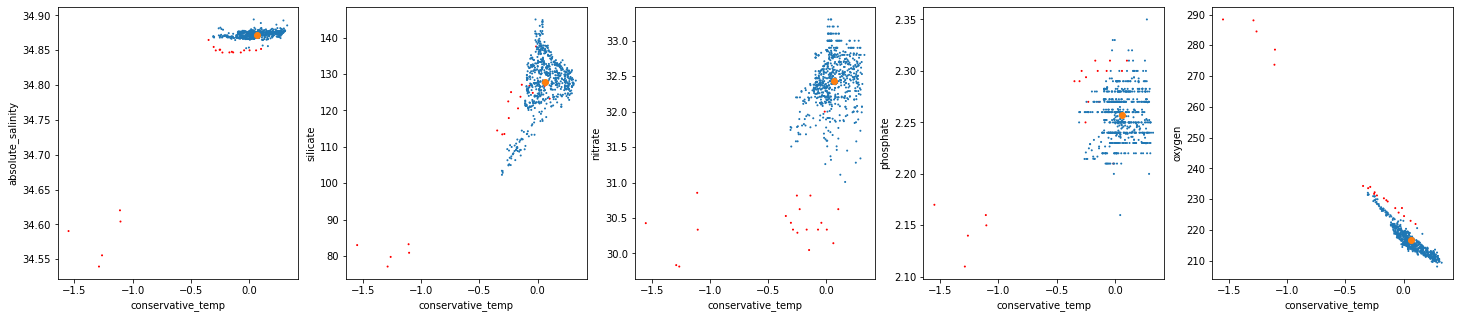

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,0.064189,34.872497,127.91465,32.430306,2.256863,216.653867,-64.042381,-72.51191,AABW_0


On water mass AAIW
Ranges: {'lat_min': -55.0, 'lat_max': -43.0, 'lon_min': -90, 'lon_max': -80, 'sig0_min': 27.05, 'sig0_max': 27.15}


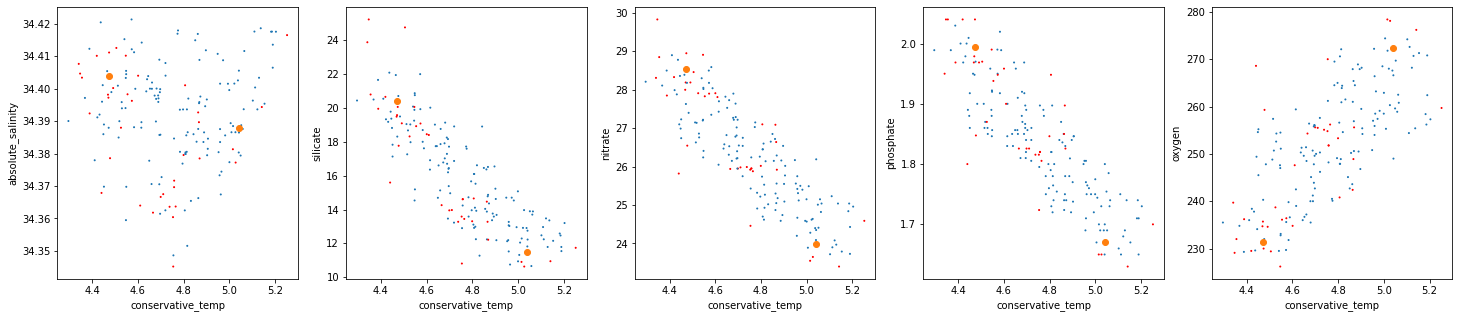

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,5.041533,34.387775,11.507342,23.991688,1.670300,272.311628,-52.777245,-85.089942,AAIW_0
1,4.472455,34.404031,20.434676,28.544067,1.994458,231.454855,-50.717571,-86.192445,AAIW_1


On water mass ENPCW
Ranges: {'lat_min': 16, 'lat_max': 26, 'lon_min': -170, 'lon_max': -140, 'sig0_min': 25.29, 'sig0_max': 26.86}


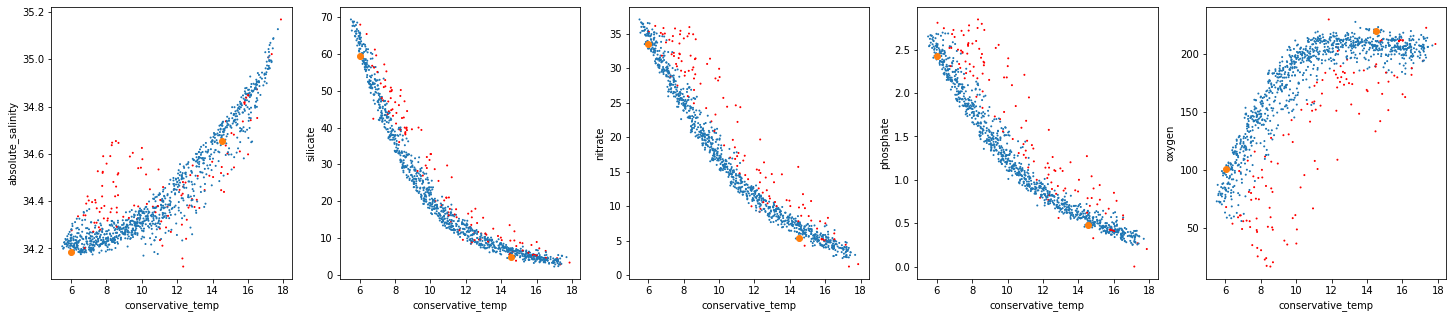

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,6.014367,34.184313,59.350000,33.530000,2.426000,100.640000,24.24500,-144.810000,ENPCW_0
1,14.524205,34.655960,4.927377,5.346612,0.475014,219.458603,24.26555,-152.638407,ENPCW_1


On water mass ESSW
Ranges: {'lat_min': -5, 'lat_max': 5, 'lon_min': -90.0, 'lon_max': -80.0, 'sig0_min': 25.29, 'sig0_max': 26.86}


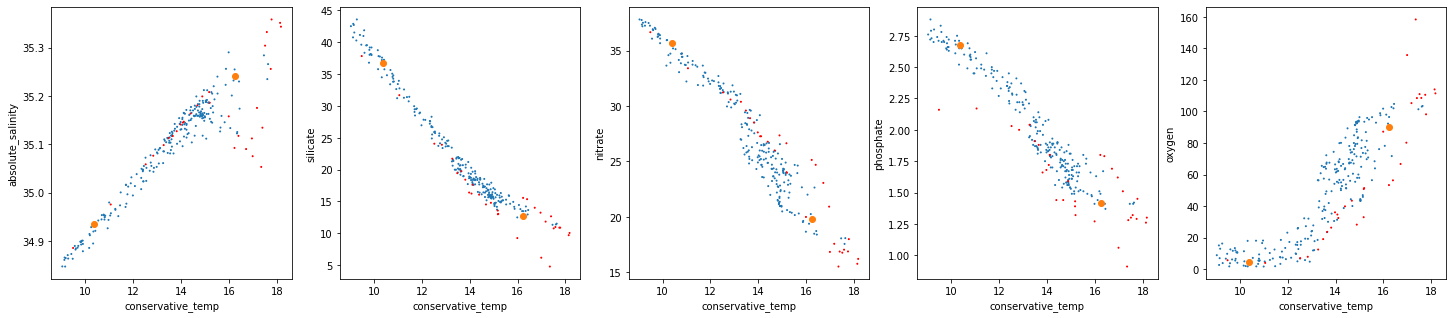

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,10.383632,34.935103,36.715215,35.715467,2.676355,4.465580,-1.782810,-85.837367,ESSW_0
1,16.246224,35.240734,12.743146,19.802518,1.418350,90.423595,-2.125636,-84.873564,ESSW_1


On water mass EqIW
Ranges: {'lat_min': -5, 'lat_max': 5, 'lon_min': -90.0, 'lon_max': -80.0, 'sig0_min': 26.86, 'sig0_max': 27.3}


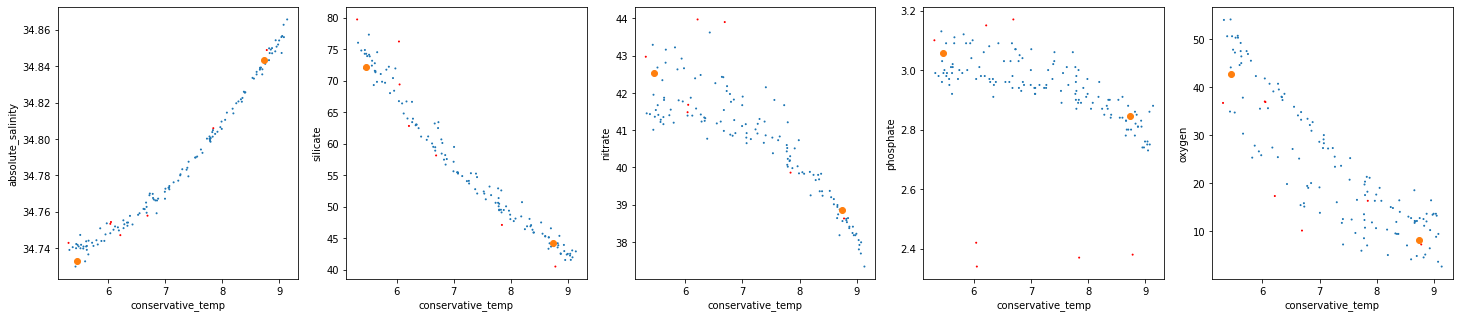

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,5.457473,34.733055,72.170937,42.522400,3.056622,42.817368,-3.463394,-85.834079,EqIW_0
1,8.739013,34.843498,44.152812,38.849067,2.845337,8.044295,-1.592680,-85.834449,EqIW_1


On water mass LCDW
Ranges: {'lat_min': -66.5, 'lat_max': -61.5, 'lon_min': -100.0, 'lon_max': 150.0, 'invert_lon': True, 'sig0_min': 27.79, 'sig0_max': 27.83}


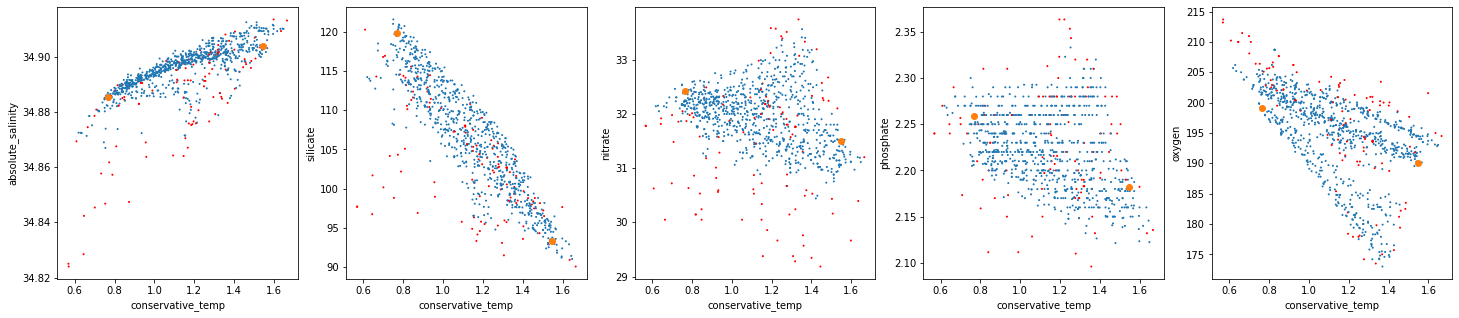

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,1.546655,34.903948,93.367489,31.503743,2.181725,190.110464,-64.086143,-139.881610,LCDW_0
1,0.767133,34.885212,119.861005,32.426893,2.258944,199.106958,-65.405059,-121.503702,LCDW_1


On water mass NPIW
Ranges: {'lat_min': 34.0, 'lat_max': 37.0, 'lon_min': 140.0, 'lon_max': 153.0, 'sig0_min': 26.5, 'sig0_max': 27.4, 'ox_min': 0, 'ox_max': 150.0}


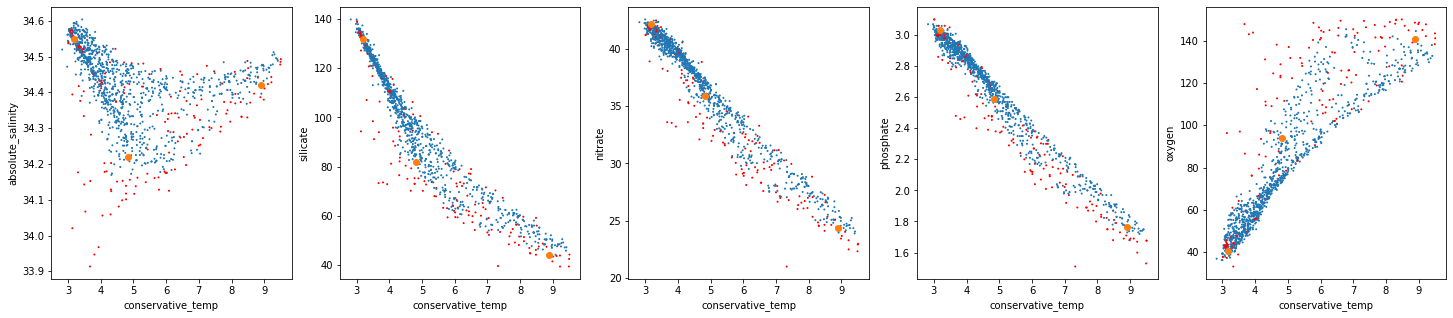

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,8.893176,34.419841,44.172545,24.386059,1.762051,140.799365,35.318749,147.041221,NPIW_0
1,4.828522,34.219261,82.093129,35.859424,2.589069,93.725973,34.648270,145.458653,NPIW_1
2,3.183510,34.549333,132.054177,42.135015,3.034531,40.417256,34.721421,146.754149,NPIW_2


On water mass PDW
Ranges: {'lat_min': 39.0, 'lat_max': 51.0, 'lon_min': -170.0, 'lon_max': -133.0, 'sig0_min': 27.6, 'sig0_max': 200, 'sig4_min': 0, 'sig4_max': 45.88}


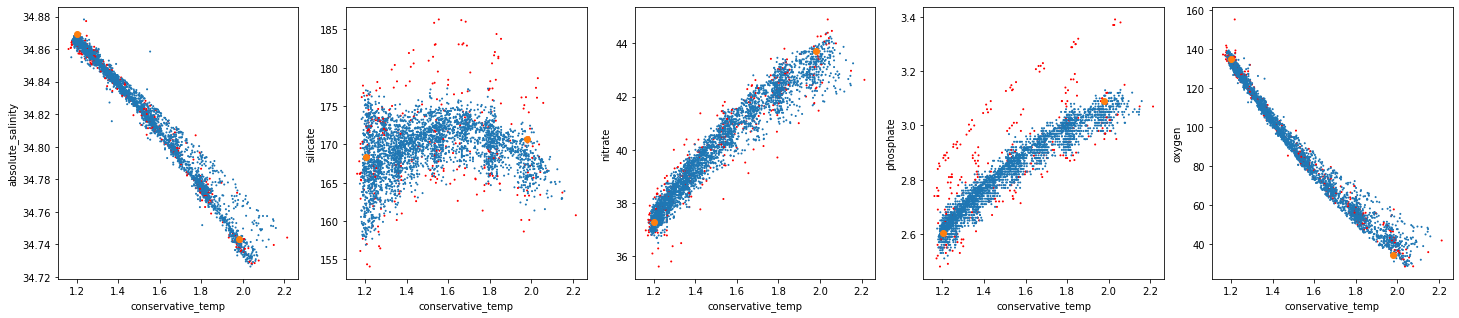

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,1.202298,34.869530,168.362069,37.270240,2.604724,135.136060,43.570134,-148.057351,PDW_0
1,1.979542,34.743524,170.741721,43.710517,3.091836,34.252017,46.620171,-151.852320,PDW_1


On water mass PSUW
Ranges: {'lat_min': 50, 'lat_max': 58, 'lon_min': -155, 'lon_max': -140, 'sig0_min': 25.29, 'sig0_max': 26.86}


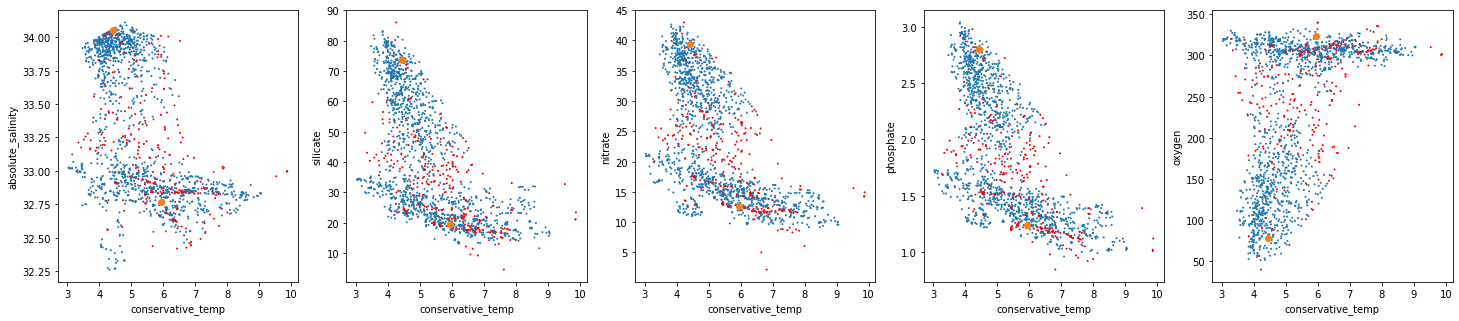

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,5.943538,32.764668,19.727946,12.600540,1.239737,323.788498,52.830812,-145.433675,PSUW_0
1,4.433156,34.053060,73.720179,39.380101,2.807316,78.560579,50.072086,-145.102609,PSUW_1


On water mass SPCW
Ranges: {'lat_min': -30, 'lat_max': -20, 'lon_min': -152, 'lon_max': -130, 'sig0_min': 25.29, 'sig0_max': 26.86}


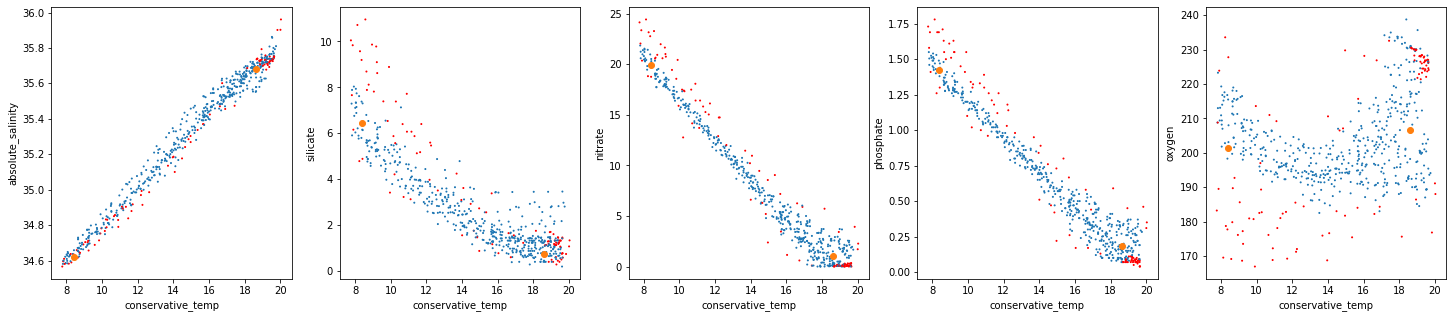

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,18.615716,35.679372,0.756201,1.036676,0.181146,206.646210,-25.048267,-147.809544,SPCW_0
1,8.395903,34.619853,6.467459,19.976265,1.427294,201.514485,-25.266930,-132.946214,SPCW_1


On water mass UCDW
Ranges: {'lat_min': -49.5, 'lat_max': -44.5, 'lon_min': -157.0, 'lon_max': -147.0, 'sig0_min': 27.35, 'sig0_max': 27.75}


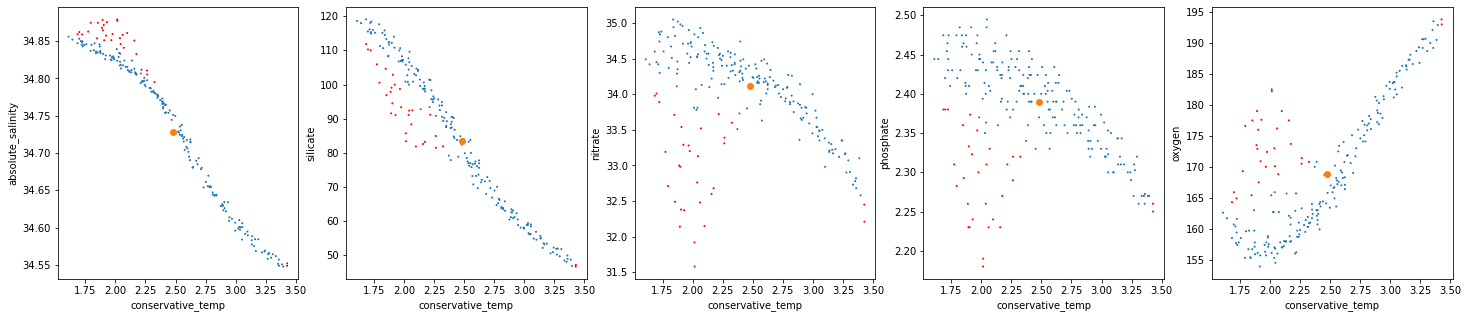

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,2.478317,34.727744,83.321879,34.1121,2.38971,168.785502,-46.663731,-150.194045,UCDW_0


In [9]:
from py_pcha import PCHA
import scipy 
from scipy import spatial
from IPython.display import display, HTML


def flag_outliers(features, n_neighbors=20, zscore_threshold=1):
    #Features is observations X features
    #Do a process of removing outliers; if the average distance of a point to
    # its nearest N neighbors is more than stdev number of standard deviations from
    # the mean, flag it as an outlier.
    #I tried the Extreme Studentized Deviate but it wasn't behaving very
    # predictably. I guess the distribution of neighbor distances is
    # exponential-ish rather than normal.
    pairwise_distances = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(X=features, metric="euclidean"))
    avg_dist_to_nn = np.mean(
        np.sort(pairwise_distances, axis=-1)[:,1:n_neighbors+1], axis=-1)
    zscore_avgdisttonn = (avg_dist_to_nn - np.mean(avg_dist_to_nn))/np.std(
                          avg_dist_to_nn)
    #plt.hist(zscore_avgdisttonn, bins=100)
    #plt.show()
    anomalous_indices = np.abs(zscore_avgdisttonn) > zscore_threshold
    return anomalous_indices


def run_archetype_analysis(df, num_endmembers):
    np.random.seed(1234) #fix seed for reproducibility of results
    all_features = np.array([np.array(df["standardized_"+col])
                      for col in ARCH_ANALYSIS_FEATURES]).transpose((1,0))
    all_origspace_features = np.array([np.array(df[col]) for col in
                                   ALL_FEATURES_TO_AVERAGE]).transpose((1,0))

    outliers = flag_outliers(all_features)
    features = all_features[outliers==False]
    origspace_features = all_origspace_features[outliers==False]

    XC, S, C, SSE, varexpl = PCHA(X=features.T, noc=num_endmembers,
                                  verbose=False)
    archetype_features = np.array(XC).T #becomes archtetypes X features
    obs_combos_giving_archetypes = np.array(C).T #archetypes X obs combos

    origspace_archetypes = obs_combos_giving_archetypes@origspace_features

    #Make scatterplots
    fig,ax = plt.subplots(nrows=1, ncols=len(ARCH_ANALYSIS_FEATURES)-1,
                          figsize=(25,5))
    pltnum = 0
    for featureidx1 in [0]:#range(len(ALL_FEATURES_TO_AVERAGE)):
        for featureidx2 in range(featureidx1+1, len(ALL_FEATURES_TO_AVERAGE)):
            if ((ALL_FEATURES_TO_AVERAGE[featureidx1]
                 in ARCH_ANALYSIS_FEATURES) and
                (ALL_FEATURES_TO_AVERAGE[featureidx2]
                 in ARCH_ANALYSIS_FEATURES)):
                plt.sca(ax[pltnum])
                plt.scatter(all_origspace_features[:,featureidx1],
                            all_origspace_features[:,featureidx2],
                            c=[("red" if x==True else "C0") for x in outliers],
                            s=1)
                plt.scatter(origspace_archetypes[:,featureidx1],
                            origspace_archetypes[:,featureidx2],
                            color="C1")
                plt.xlabel(ALL_FEATURES_TO_AVERAGE[featureidx1])
                plt.ylabel(ALL_FEATURES_TO_AVERAGE[featureidx2]) 
                pltnum += 1
    plt.show()

    return pandas.DataFrame(dict([(colname, origspace_archetypes[:,idx])
                        for idx,colname in enumerate(ALL_FEATURES_TO_AVERAGE)]))
    

#num_archetypes is not really a filter condition but this is the easiest
# place to store that feature
filter_conditions = {
    "AAIW": {"lat_min":-55.0, "lat_max":-43.0,
             "lon_min":-90, "lon_max":-80,
             "sig0_min":27.05, "sig0_max":27.15,
             "num_archetypes":2},
    "NPIW": {"lat_min":34.0, "lat_max":37.0, 
             "lon_min":140.0, "lon_max":153.0, 
             "sig0_min":26.5, "sig0_max":27.4, 
             "ox_min":0, "ox_max":150.0,
             "num_archetypes":3},
    "UCDW": {"lat_min":-49.5, "lat_max":-44.5, 
             "lon_min":-157.0, "lon_max":-147.0,
             "sig0_min":27.35, "sig0_max":27.75,
             "num_archetypes":1},
    "LCDW": {"lat_min":-66.5, "lat_max":-61.5, 
             "lon_min":-100.0, "lon_max":150.0,
             "invert_lon":True,
             "sig0_min":27.79, "sig0_max":27.83,
             "num_archetypes":2},
    "AABW": {"lat_min":-66.5, "lat_max":-61.5, 
             "lon_min":-100.0, "lon_max":150.0,
             "invert_lon":True,
             "sig4_min":46.04, "sig4_max":200,
             "num_archetypes":1},
    "PDW": {"lat_min":39.0, "lat_max":51.0, 
             "lon_min":-170.0, "lon_max":-133.0,
             "sig0_min":27.6, "sig0_max":200,
             "sig4_min":0, "sig4_max":45.88,
             'num_archetypes':2},
   #"PDW1": {"lat_min":55.0, "lat_max":60.0,
            #"lon_min":160.0, "lon_max":170.0,
            #"sig0_min":27.6, "sig0_max":200,
            #"sig2_min":0, "sig2_max":36.96,
            #'num_archetypes':1},
   #"PDW2&3": {"lat_min":39.0, "lat_max":51.0,
            #"lon_min":-170.0, "lon_max":-133.0,
            #"sig2_min":0, "sig2_max":36.96,
            #"sig4_min":0, "sig4_max":45.88,
            #'num_archetypes':1},
    "EqIW": {"lat_min":-5, "lat_max":5, 
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 26.86, "sig0_max": 27.3,
             "num_archetypes":2},
    "PSUW": {"lat_min":50, "lat_max":58, 
             "lon_min":-155, "lon_max":-140,
             "sig0_min": 25.29, "sig0_max": 26.86,
             "num_archetypes":2},
    "ENPCW": {"lat_min":16, "lat_max":26, 
             "lon_min":-170, "lon_max":-140,
             "sig0_min": 25.29, "sig0_max": 26.86,
             "num_archetypes":2},
    "ESSW": {"lat_min":-5, "lat_max":5, 
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 25.29, "sig0_max": 26.86,
             "num_archetypes":2},
    "SPCW": {"lat_min":-30, "lat_max":-20, 
             "lon_min":-152, "lon_max":-130, 
             "sig0_min": 25.29, "sig0_max": 26.86,
             "num_archetypes":2},
    #"SPSTSW": {"lat_min":-20, "lat_max":-15, 
             #"lon_min":-152, "lon_max":-142, 
             #"sig0_min": 25.29, "sig0_max": 26.86,
             #"num_archetypes":2}
}

def filter_rows(df, lat_min, lat_max, lon_min, lon_max,
                invert_lon=False,
                sig0_min=0, sig0_max=np.inf, 
                sig2_min=0, sig2_max=np.inf,
                sig4_min=0, sig4_max=np.inf,
                ox_min=0, ox_max=np.inf):
  return df[(df["latitude"] >= lat_min) &
            (df["latitude"] <= lat_max) &
            (((df["longitude"] >= lon_min) &
              (df["longitude"] <= lon_max))
              ==(False if invert_lon else True)) &
            (df["sigma0"] >= sig0_min) &
            (df["sigma0"] <= sig0_max) &
            (df["sigma2"] >= sig2_min) &
            (df["sigma2"] <= sig2_max) &
            (df["sigma4"] >= sig4_min) &
            (df["sigma4"] <= sig4_max) &
            (df["oxygen"] >= ox_min) &
            (df["oxygen"] <= ox_max) 
            ]

watermass_to_archetypes = {}

for watermass in sorted(filter_conditions.keys()):
  print("On water mass", watermass)
  num_archetypes = filter_conditions[watermass]['num_archetypes']
  del filter_conditions[watermass]['num_archetypes']
  print("Ranges:", filter_conditions[watermass])
  watermass_rows = filter_rows(df=df, **filter_conditions[watermass])
  watermass_archetypes = run_archetype_analysis(
      df=watermass_rows,
      num_endmembers=num_archetypes)
  watermass_archetypes["watermass_name"] = [watermass+"_"+str(i)
                                            for i in range(num_archetypes)]
  watermass_to_archetypes[watermass] = watermass_archetypes
  display(watermass_archetypes)

full_watermass_df = pandas.concat([watermass_to_archetypes[watermass]
                          for watermass in sorted(watermass_to_archetypes.keys())])

In [10]:
full_watermass_df.to_csv("GP15_intermediateanddeep_endmemberswithsubtypes_July11.csv",
                         columns=["watermass_name"]+ALL_FEATURES_TO_AVERAGE,
                         index=False)

Let's also plot the locations (on the globe) corresponding to the filtered data frames

AABW


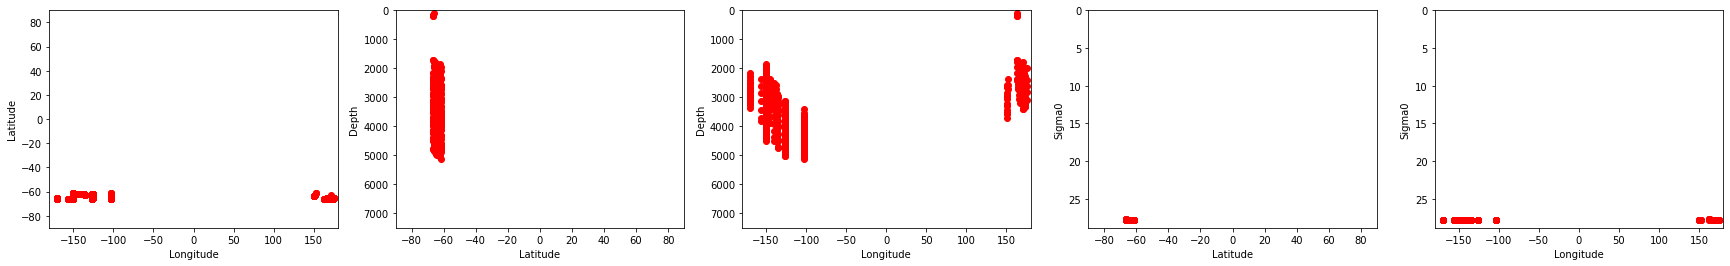

AAIW


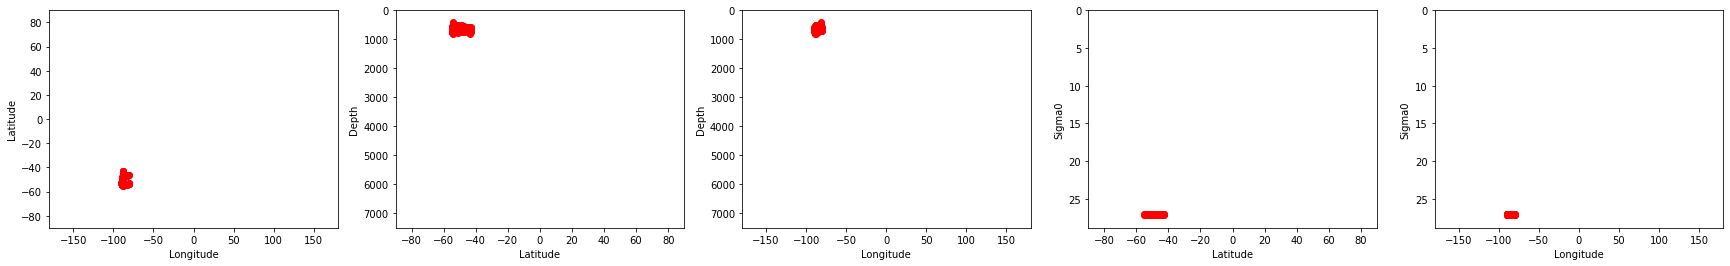

ENPCW


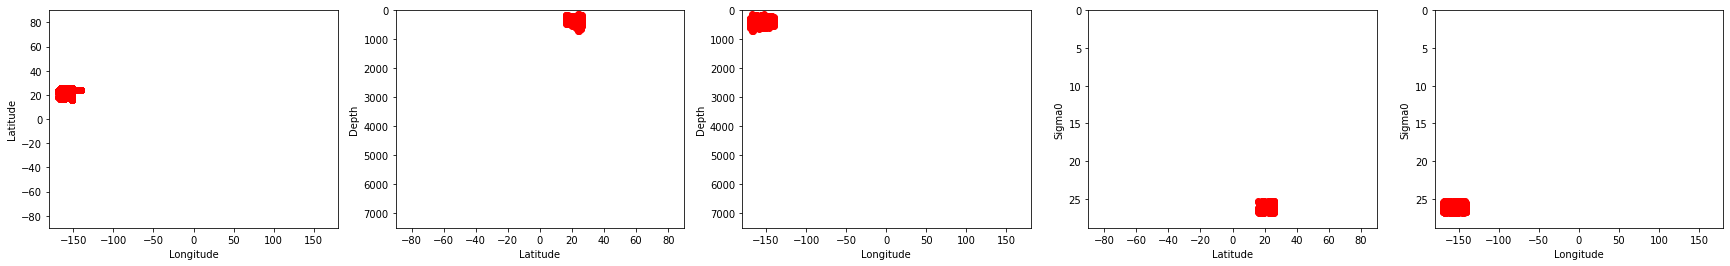

ESSW


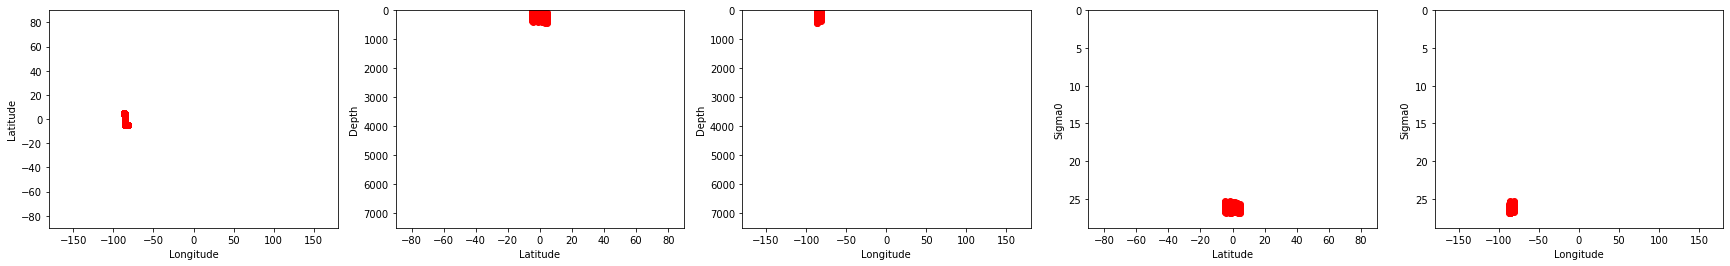

EqIW


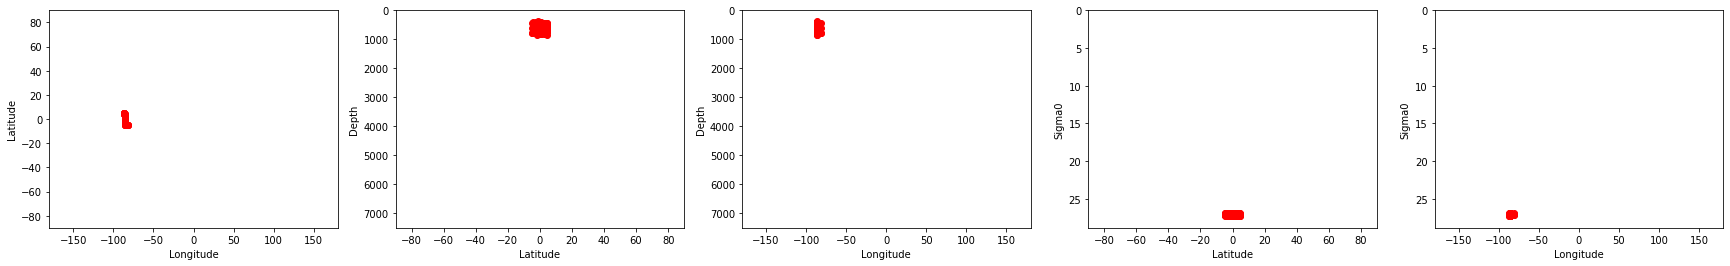

LCDW


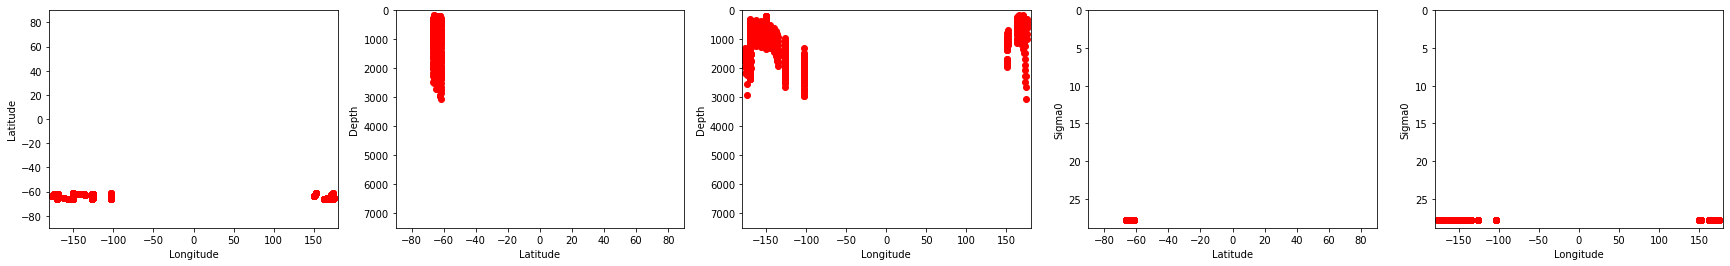

NPIW


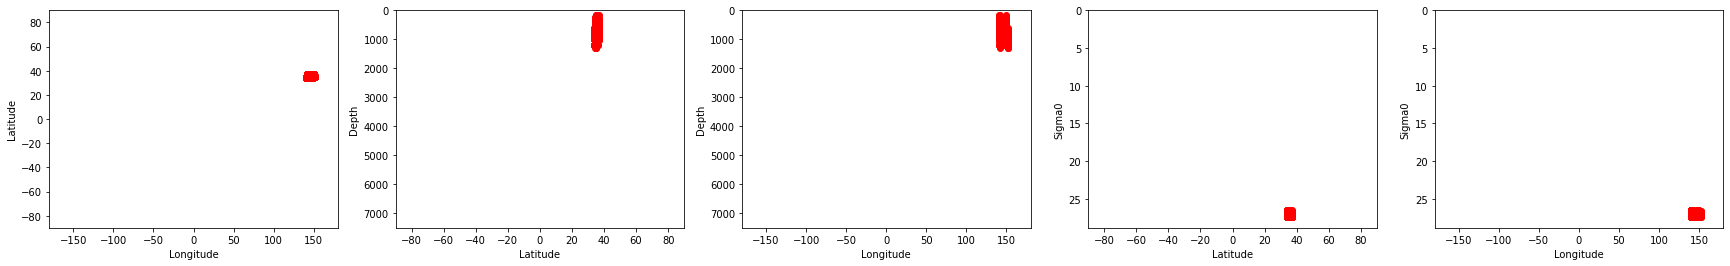

PDW


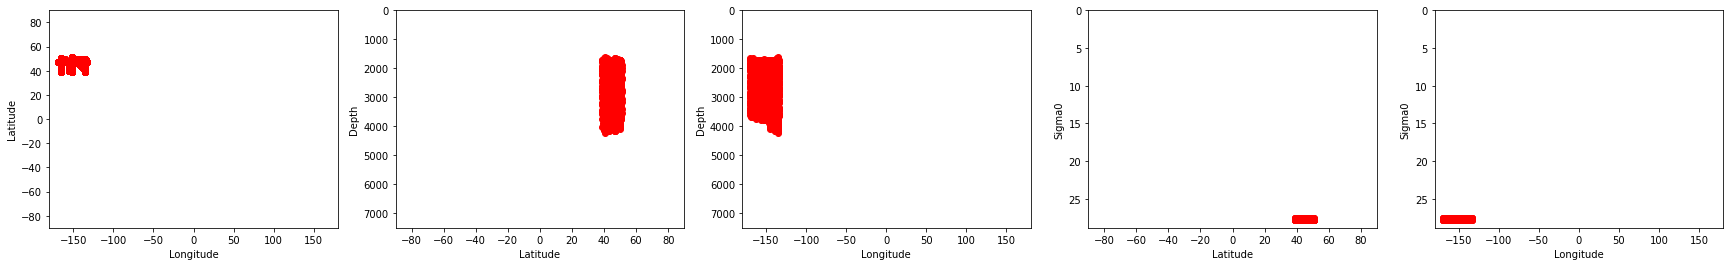

PSUW


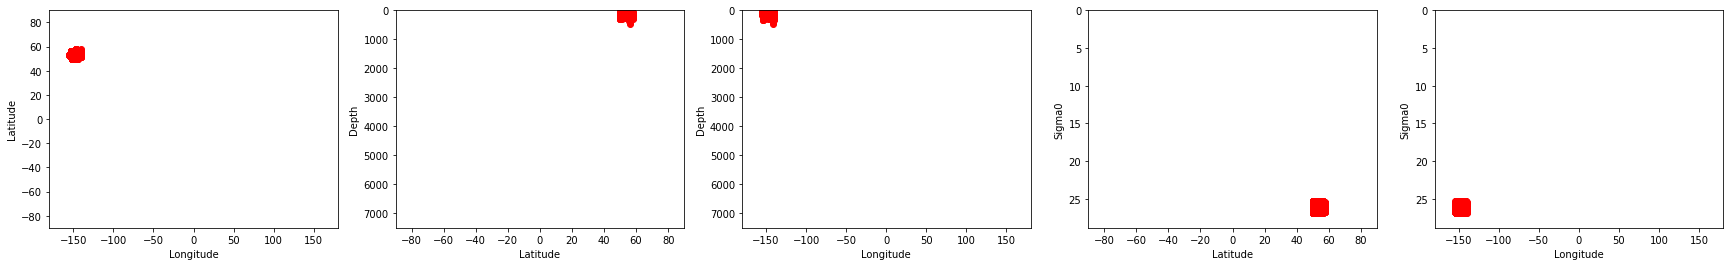

SPCW


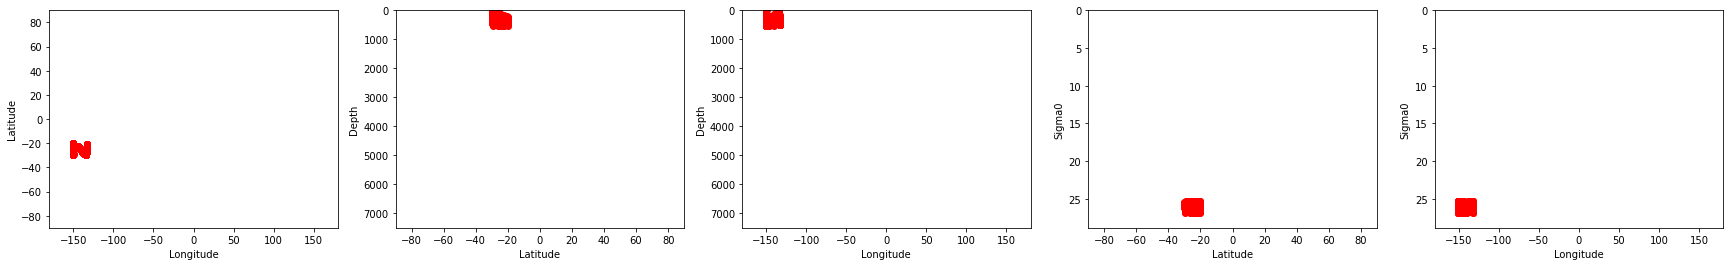

UCDW


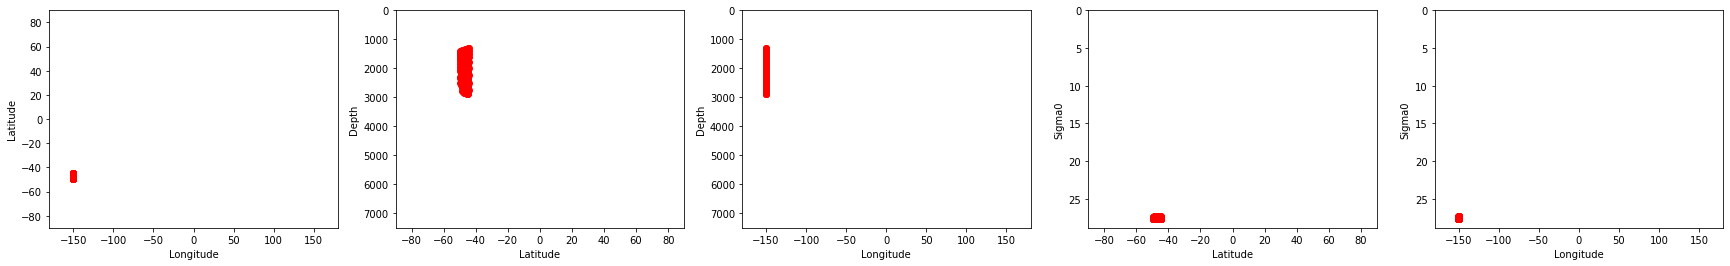

In [11]:
endmem_names = sorted(filter_conditions.keys())
max_depth = np.max(df["depth"])
max_sig0 = np.max(df["sigma0"])

for endmem in endmem_names:
    print(endmem)
    watermass_rows = filter_rows(df=df, **filter_conditions[endmem])

    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(30,4))

    plt.sca(ax[0])
    plt.scatter(
        watermass_rows["longitude"], watermass_rows["latitude"], color="red")
    plt.xlim(-180, 180)
    plt.ylim(-90, 90)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    #plt.show()

    plt.sca(ax[1])
    plt.scatter(
        watermass_rows["latitude"], watermass_rows["depth"], color="red")
    plt.xlim(-90,90)
    plt.ylim(max_depth,0)
    plt.xlabel("Latitude")
    plt.ylabel("Depth")
    #plt.show()

    plt.sca(ax[2]) 
    plt.scatter(
        watermass_rows["longitude"], watermass_rows["depth"], color="red")
    plt.xlim(-180,180)
    plt.ylim(max_depth,0)
    plt.xlabel("Longitude")
    plt.ylabel("Depth")
    #plt.show()

    plt.sca(ax[3])
    plt.scatter(
        watermass_rows["latitude"], watermass_rows["sigma0"], color="red")
    plt.xlim(-90,90)
    plt.ylim(max_sig0,0)
    plt.xlabel("Latitude")
    plt.ylabel("Sigma0")
    #plt.show()

    plt.sca(ax[4]) 
    plt.scatter(
        watermass_rows["longitude"], watermass_rows["sigma0"], color="red")
    plt.xlim(-180,180)
    plt.ylim(max_sig0,0)
    plt.xlabel("Longitude")
    plt.ylabel("Sigma0")
    plt.show()
